In [3]:
from utilsGeneral import UtilsGeneral
from utilsModel import UtilsModel
from utilsPlot import UtilsPlot
from KnapSack import KnapSack
from shallowNet.shallowNet import shallowNet, DenseTranspose
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import transforms
import math
import scipy.stats as stats
import collections
import matplotlib.cm as cm




In [4]:
knapSack = KnapSack("100_5_25_1")
utg = UtilsGeneral(knapSack)
utm = UtilsModel(utg)
utp = UtilsPlot(utilsGeneral = utg, utilsModel = utm)
fitness_function = knapSack.Fitness

Best Objective Value: 0


In [5]:
set1, set2 = utg.load_datasets(1,2)
model1, model2, model3= utg.load_models(1,2, 3)

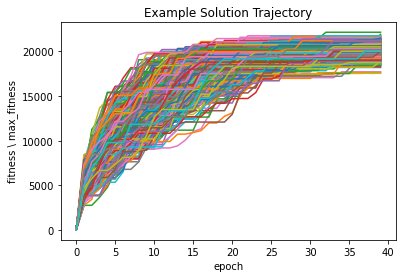

In [7]:
max_fitness, final_solutions = utp.plot_trajectory_evolution(100, learning_steps = 40, sample_number=600, model = model2)

In [43]:
def TrainToSol(sol):
    ConvertSol = np.copy(sol)
    ConvertSol[sol == -1] = 0
    return ConvertSol

def SolDistribution(sol):
    size = np.shape(sol)[-1]
    arr = np.zeros(size)
    for i in sol:
        arr += TrainToSol(i)
    return arr/ np.shape(sol)[0]



def che(sol):
    arr = SolDistribution(sol)
    return AverageElements(arr)

In [13]:
def plot_distribution(sol, title = "Independent probability distribution", xl = "Bit position", yl ="Probability"):
    plt.figure()
    plt.title(title)
    plt.bar(np.arange(len(sol)), sol, align = "center", alpha = 0.5)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.show()

768.42  -  172.39386183968384


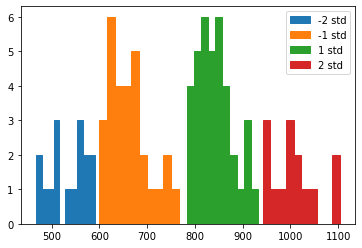

In [10]:
array =  knapSack.P.tolist()
lambda_cof = 1
std = 172.39386183968384
numbers_of_partition = 2
mean = 768.42
print(mean, " - ", std)
arraycopy = copy.copy(array)
res = []
mapindex = {}
stop = False
for i in range(1,numbers_of_partition+1): 
    tmp_left = []
    tmp_right = []
    array_len = len(arraycopy)
    for j in range(array_len):
        element = arraycopy.pop(0)
        if element >= mean - i * std/lambda_cof and element <= mean:
            tmp_left.append(element)
        elif element >= mean and element <= mean + i * std/lambda_cof:
            tmp_right.append(element)
        else:
            arraycopy.append(element)

    res.insert(0, np.asarray(tmp_left))
    res.append(np.asarray(tmp_right))    
for i in range(numbers_of_partition*2):
    
    index = -numbers_of_partition+i
    if i >= numbers_of_partition:
        index += 1
    plt.hist(res[i], histtype='step', stacked=True, fill=True, label = "{} std".format(index))
plt.legend()
plt.show()


In [11]:
def partition(array, numbers_of_partition=2, lambda_cof=1, mean= None, std = None):
    def get_index_list(array, element):
        return [i for i, e in enumerate(array) if e == element]
    if type(array) != type([1,2]):
        array = array.tolist()
    if std == None:
        std = np.std(array)
    if mean == None:
        mean = np.sum(array)/np.shape(array)[0] ### idk why np.mean(...) does not work 
    arraycopy = copy.copy(array)
    res = []
    mapindex = {}
    stop = False
    for i in range(1,numbers_of_partition+1): 
        tmp_left = []
        tmp_right = []
        array_len = len(arraycopy)
        for j in range(array_len):
            element = arraycopy.pop(0)
            if mapindex.get(element) == None:
                    mapindex[element] = get_index_list(array, element)
            if i == numbers_of_partition:
                if element < mean:
                    tmp_left.append(mapindex[element].pop())
                else:
                    tmp_right.append(mapindex[element].pop())
            else:
                if element >= mean - i * std/lambda_cof and element <= mean:
                    tmp_left.append(mapindex[element].pop())
                    
                elif element >= mean and element <= mean + i * std/lambda_cof:
                    tmp_right.append(mapindex[element].pop())
                else:
                    arraycopy.append(element)
                
        res.insert(0, np.asarray(tmp_left))
        res.append(np.asarray(tmp_right))

    return res, mean, std

In [12]:
def choose_group():
    p = [0.2, 0.3, 0.3, 0.2]
    r = np.random.choice(np.arange(len(p)),1, p=p)[0]
    x = np.random.choice(np.arange(2),1, p = [0.2, 0.8])[0]
    length = len(p)
    if r+x>length-1:
        x-=1
    return r, r+x

def flip(solution, index_one, index_two):
    solution[index_one] *= -1
    solution[index_two] *= -1
    return

def search_function(array, par, choosing_group_function = None, debuge_variation=False):
    if choosing_group_function == None:
        choosing_group_function = choose_group
    i_one, i_two = choosing_group_function()
    par = par[0]

    group_one = par[i_one]
    group_two = par[i_two]

    if len(group_one) == 0 or len(group_two) == 0:
        utg.flip(array, 100)
        return
    index_one = np.random.randint(len(group_one))
    index_two = np.random.randint(len(group_two))

    if not debuge_variation:
        flip(array, group_one[index_one], group_two[index_two])
    else:
        print(array)
        print(i_one, ", ", i_two, " partition shape: ", np.shape(par))
        print("index_one: ", index_one," -> " ,group_one[index_one], " = ", array[group_one[index_one]] )
        print("index_two: ", index_two," -> " ,group_two[index_two], " = ", array[group_two[index_two]] )
        flip(array, group_one[index_one], group_two[index_two])
        print("index_one: ", index_one," -> " ,group_one[index_one], " = ", array[group_one[index_one]] )
        print("index_two: ", index_two," -> " ,group_two[index_two], " = ", array[group_two[index_two]] )
    

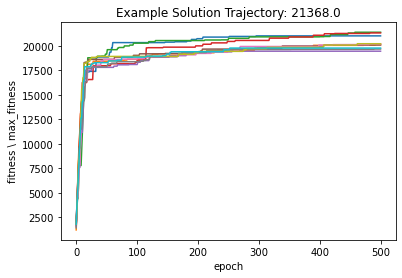

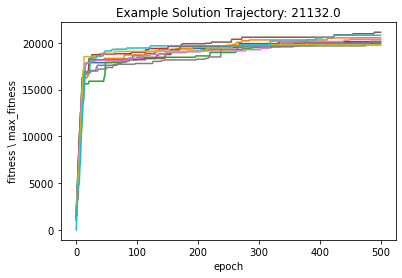

In [19]:
def plot_trajectory(sample_size, search = None, sample_number=10, learning_steps=100, transfer_step = 50, model=None, debuge_variation=False):
    global_solution = []
    par = []
    current_solutions_container = [utg.initialize_solution(sample_size) for i in range(sample_number)]
    max_fitness = 0
    for i in range(learning_steps):
        if i <transfer_step -1: 
            search = utg.flip
        else:
            if i % (transfer_step -1) == 0:
                par = partition(knapSack.P, numbers_of_partition=2, lambda_cof=1)    
        tmp_his = []
        for j in range(sample_number):
            copy_solution = copy.copy(current_solutions_container[j])
            if i > (transfer_step -1): 
                search_function(copy_solution, par = par, choosing_group_function = choose_group, debuge_variation = False)
            else:
                utg.flip(copy_solution, sample_size)
            current_fitness = fitness_function(current_solutions_container[j])
            new_fitness = fitness_function(copy_solution)
            if new_fitness > current_fitness:
                current_solutions_container[j] = copy_solution
                current_fitness = new_fitness
            tmp_his.append(current_fitness)
            if current_fitness >= max_fitness:
               max_fitness =current_fitness
            


        global_solution.append(np.asarray(tmp_his))
    global_solution = np.asarray(global_solution)
    plt.figure()
    plt.title("Example Solution Trajectory: {}".format(max_fitness))
    X = np.arange(learning_steps)
    for j in range(sample_number):
        plt.plot(X, global_solution[:,j])
    plt.xlabel("epoch")
    plt.ylabel("fitness \ max_fitness")
    plt.show()
        
    return global_solution, par
glob1, par1 = plot_trajectory(100, learning_steps= 500, transfer_step = 100)
_ =plot_trajectory(100, learning_steps= 500, transfer_step = 2000)


In [8]:
def code(array, encoder, input_size=None, latent_size=None, debuge_variation=False):
    if input_size == None:
        input_size = len(array) # if input_size is implicit do not waist time to calcule it
    if latent_size == None:
        latent_size = np.shape(encoder.layers[-1].get_weights()[0])[-1] # if latent_size is implicit do not waist time to calcule it
    encoded_solution = encoder(np.expand_dims(array, axis = 0)).numpy().flatten() # encode array 
    return encoded_solution

def decod(encoded_solution, decoder, latent_size, output_size):
    new_tensor = decoder(encoded_solution.reshape(1,latent_size)) # decode changed solution 
    output_array_binary = np.where(new_tensor.numpy()[-1] > 0.0, 1, -1)  # binarize decoded tensor around 0.0
    new_fitness = fitness_function(output_array_binary) # calculate new fitness
    return output_array_binary, new_fitness

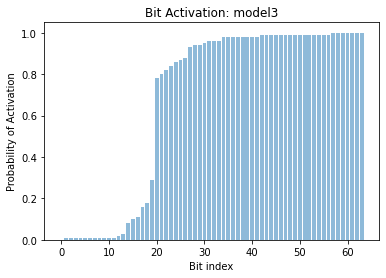

In [22]:
e, d = utm.split_model_into_encoder_decoder(model3)
def latent_activation(model, title, xl, yl):
    encoder, decoder = utm.split_model_into_encoder_decoder(model)
    size = e.layers[0].input_shape[0][-1]
    latent_size = np.shape(encoder.layers[-1].get_weights()[0])[-1]
    res = np.zeros(latent_size)
    for i in range(size):
        arr = np.zeros(size)
        arr[i] = 1
        res += np.where(code(arr, encoder) < 0.0, 0, 1)/size
    res.sort()
    plot_distribution(res, title,xl,yl)
    return
latent_activation(model3, "Bit Activation: model3", "Bit index", "Probability of Activation")

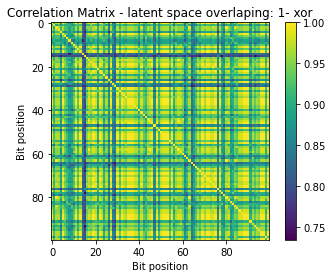

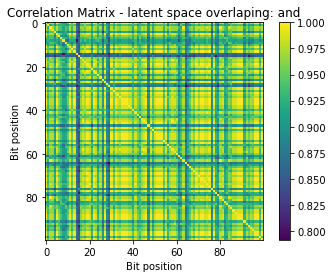

In [21]:
def correlation_matrix(model, xor = True, and_ = False):
    def latent_activation(model):
        encoder, decoder = utm.split_model_into_encoder_decoder(model)
        size = e.layers[0].input_shape[0][-1]
        res = []
        for i in range(size):
            arr = np.zeros(size)
            arr[i] = 1
            res.append(np.where(code(arr, encoder) < 0.0, 0, 1))
        return res

    def correlation(array1, array2):
        if xor: # how many bits overlap 
            return np.mean(1 - np.bitwise_xor(array1, array2))    
        if and_: # how many 1's overlap 
            mean = np.sum(np.bitwise_and(array1, array2))
            return 0.5 * mean / np.sum(array1) + 0.5 * mean / np.sum(array2)
            
    if not np.logical_xor(xor, and_):
        return

    encoded_bit_representation =latent_activation(model)
    sample_numbers = np.shape(encoded_bit_representation)[0]
    conv = []
    for i in range(sample_numbers):
        tmp = []
        for j in range(sample_numbers):
            tmp.append(
                correlation(
                    encoded_bit_representation[i], 
                    encoded_bit_representation[j]
                    ))
        conv.append(np.asarray(tmp))
    return np.asarray(conv)
def plot_correlation_matrix(model, xor=False, and_ = True):
    plt.figure()
    res =correlation_matrix(model, xor, and_)
    plt.imshow(res, interpolation='nearest')
    if xor:
        plt.title("Correlation Matrix - latent space overlaping: 1- xor")
    else:
        plt.title("Correlation Matrix - latent space overlaping: and")
    plt.xlabel("Bit position")
    plt.ylabel("Bit position")
    plt.colorbar()
plot_correlation_matrix(model3, xor = True, and_ = False)
plot_correlation_matrix(model3, xor = False, and_ = True)


In [22]:
def plot_latent_activation_distribution(set_, model, probability = False, sort = False, show = True, model_name = "", plot_name = None):
    def AllPositivesToZero(sol):
        ConvertSol = np.copy(sol)
        if probability:
            return  np.where(sol > 0.0, 1, 0)
        ConvertSol[sol >= 0] = 0
        return ConvertSol
    def AllNegativesToZero(sol):
        ConvertSol = np.copy(sol)
        if probability:
            return np.where(sol > 0.0, 0, 1)
        ConvertSol[sol < 0] = 0
        return ConvertSol

    e, d= utm.split_model_into_encoder_decoder(model)
    res_pos = []
    res_neg = []
    latent_size = np.shape(e.layers[-1].get_weights()[0])[-1]
    final_pos = np.zeros(latent_size)
    final_neg = np.zeros(latent_size)
    for i in set_:
        res_pos.append(AllNegativesToZero(code(i,e)))
        res_neg.append(AllPositivesToZero(code(i,e)))
    for i in res_pos:
        final_pos += i
    for i in res_neg:
        final_neg += i

    final_pos = final_pos/len(final_solutions)
    if probability:
        final_neg = final_neg/len(final_solutions) 
    else: 
        final_neg = final_neg/len(final_solutions) *(-1)

    if sort: 
        final_neg.sort()
        final_pos[::-1].sort()

    partition_, mean, std = partition(final_pos, numbers_of_partition=2)
    partition_size = len(partition_)
    std_lines = []
    set_lines = []
    for arr in partition_:
        set_lines.append(arr[-1])
    set_lines.pop(0)

    for i in range(1,int(partition_size/2)):
        std_lines.append(i*std + mean)
        std_lines.append(-i*std + mean)


    plt.figure()
    if probability:
        base = plt.gca().transData
        rot = transforms.Affine2D().rotate_deg(90)
        plt.bar(np.arange(len(final_pos)),-final_pos, color='blue', alpha = 0.7, label = "+p",transform = rot + base)
        plt.bar(range(len(final_neg)), -final_neg, bottom = -np.array(final_pos), color = "red", alpha = 0.7, label = "-p", transform = rot + base)
        #plt.gca().invert_xaxis()
        if sort:
            for xc in std_lines:
                plt.axvline(x = xc , color ="black", linestyle = '--')
            plt.axvline(x = mean, color = "black", linestyle = '--')
            for yc in set_lines: 
                plt.axhline(y = yc, color = "black", linestyle = '-')
            plt.title("+/-probability distributioin {}: stacked + sorted".format(model_name))
        else:
            plt.title("+/-probability distributioin {}: stacked".format(model_name))
        plt.xlabel("Probability")
        plt.ylabel("Bit positions")
        plt.legend()
    else:
        plt.bar(np.arange(len(final_pos)),final_pos,label = "Positive values", alpha = 0.5, color = "red")
        plt.bar(np.arange(len(final_neg)),final_neg, label = "Negative values * (-1)", alpha = 0.5, color = "blue")
        plt.title("+/- average bit values distributioin {}:".format(model_name))
        plt.ylabel("Average Value")
        plt.xlabel("Bit positions")
        plt.legend()
    if plot_name != None:
        path = utg.create_plot_path(plot_name)
        plt.savefig(path)
    return final_pos, final_neg, partition_

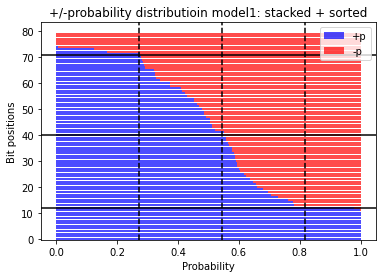

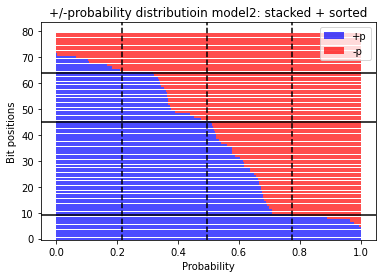

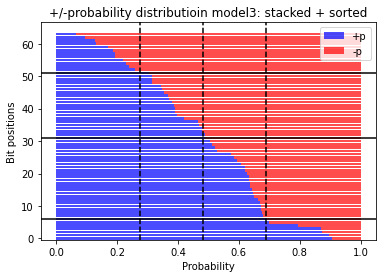

In [23]:
_ = plot_latent_activation_distribution(final_solutions, model1, probability = True, sort = True, model_name = "model1")
_ =plot_latent_activation_distribution(final_solutions, model2, probability = True, sort = True, model_name = "model2")
fp, fn, par  =plot_latent_activation_distribution(final_solutions, model3, probability = True, sort = True, model_name = "model3")
#fp, fn = plot_latent_activation_distribution(final_solutions, model3, probability = True, show= False, model_name = "model3")

In [24]:
par

[array([52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),
 array([34, 33, 35, 36, 37, 38, 40, 39, 41, 42, 43, 44, 45, 46, 47, 48, 50,
        49, 51]),
 array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 16, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29, 30, 32, 31]),
 array([0, 1, 2, 3, 4, 5, 6])]

([array([52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),
  array([34, 33, 35, 36, 37, 38, 40, 39, 41, 42, 43, 44, 45, 46, 47, 48, 50,
         49, 51]),
  array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 16, 18, 19, 20, 21, 22, 23,
         24, 25, 26, 27, 28, 29, 30, 32, 31]),
  array([0, 1, 2, 3, 4, 5, 6])],
 0.4833072916666667,
 0.20754046881712396)

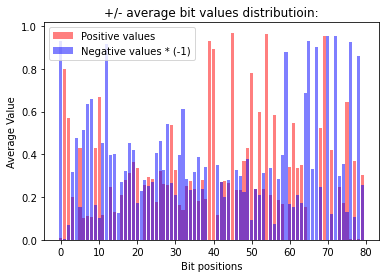

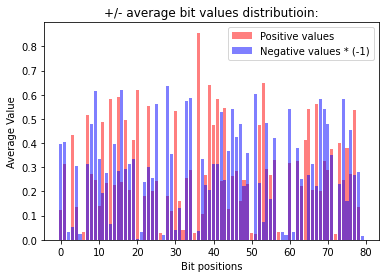

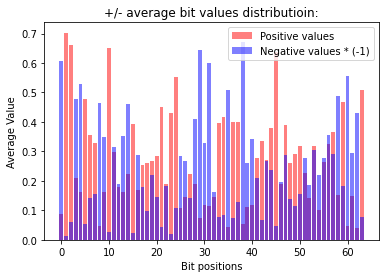

In [1002]:
_ = plot_latent_activation_distribution(final_solutions, model1, probability = False)
_ =plot_latent_activation_distribution(final_solutions, model2, probability = False)
_ =plot_latent_activation_distribution(final_solutions, model3, probability = False)

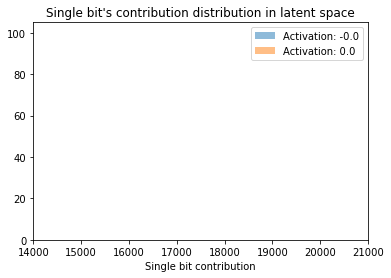

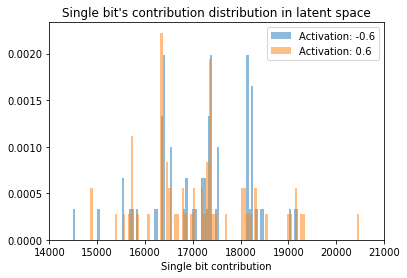

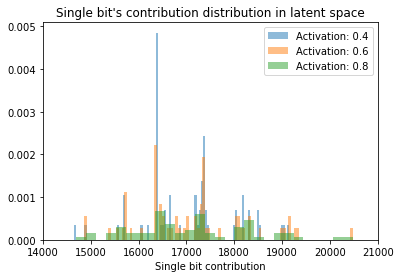

In [26]:
def plot_histogram_value_contribution(model, activation_value = (1)):

    e, d= utm.split_model_into_encoder_decoder(model)
    size = np.shape(e.layers[-1].get_weights()[0])[-1]
    for activation in activation_value:
        
        result = []
        for i in range(size):
            tmp = np.zeros(size)
            tmp[i] = activation
            result.append(decod(tmp, d, size, knapSack.Size)[-1])
        result = np.asarray(result)
        plt.hist(result, bins = 100,  density=True, histtype='bar', stacked=True, alpha =0.5, label = "Activation: {}".format(activation))
    plt.legend()
    plt.title("Single bit's contribution distribution in latent space")
    plt.xlabel("Single bit contribution")
    axes = plt.gca()
    axes.set_xlim([14000,21000])
    plt.show()

plot_histogram_value_contribution(model3, (-0.0,0.0))
plot_histogram_value_contribution(model3, (-0.6,0.6))
plot_histogram_value_contribution(model3, (0.4,0.6,0.8))


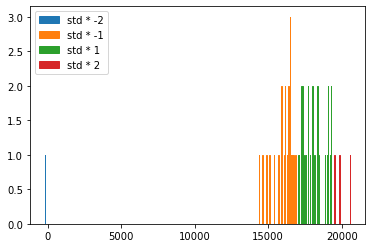

In [834]:
par2 = partition(result)
index = -2
glob = []
for arr in par2: 
    res = []
    for elem in arr:
        tmp = np.zeros(64)
        tmp[elem] = 1
        res.append(decod(tmp, d, 64, 100)[-1])
    plt.hist(res, bins = 100,histtype='step', stacked=True, fill=True, label = "std * {}".format(index))
    list.sort(res)
    glob.append(np.asarray(res))
    index +=1
    if index == 0:
        index +=1
plt.legend()
plt.show()



<BarContainer object of 64 artists>

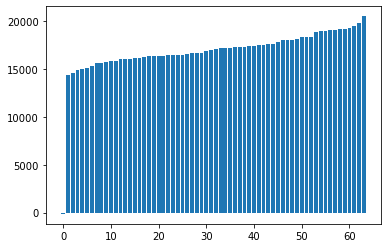

In [820]:
tmp = np.concatenate(glob, axis =0)
plt.bar(np.arange(64), tmp)

In [70]:
epochs = 200
batch_size = 10

[INFO]: Loss plot was saved in the directory:  saved_plots\to_delete.png


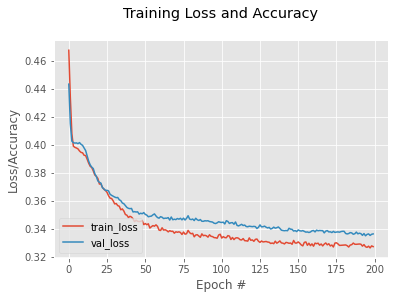

In [157]:
model4 = utm.add_layer_to_model(model2, compression=0.8, dropout=0.0, reg_cof=0.0002,lr = 0.002, show_summary=False)
H4 = model4.fit(
    set2, set2, 
    validation_split = 0.1,
    epochs=epochs, 
    batch_size=batch_size, 
    shuffle=True,
    verbose=0)
utp.plot_model_loss(H4, "to_delete.png", epochs)

In [80]:
tmp1 = np.zeros(100)
tmp2 = np.zeros(100)
tmp1[0] = 1

In [ ]:
def convolution()

[INFO]: Loss plot was saved in the directory:  saved_plots\to_delete.png


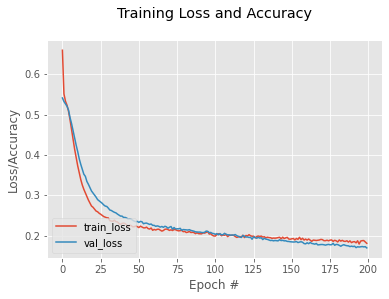

In [24]:
compression = 0.8
epochs = 200
batch_size = 10
reg_cof = 0.0002
dropout = 0.2
lr = 0.002

model1 = shallowNet.build(
    input_shape=knapSack.Size, 
    reg_cof= reg_cof, 
    lr = lr, 
    dropout= dropout, 
    compression=compression
)

H1 = model1.fit(
    trainY1, trainY1, 
    validation_split = 0.05,
    epochs=epochs, 
    batch_size=batch_size, 
    shuffle=True,
    verbose=0)
utp.plot_model_loss(H1, "to_delete.png", epochs)



[INFO]: Trajectory evoultion plot was saved in the directory:  saved_plots\to_delete.png
[INFO]: Trajectory evoultion plot was saved in the directory:  saved_plots\to_delete.png


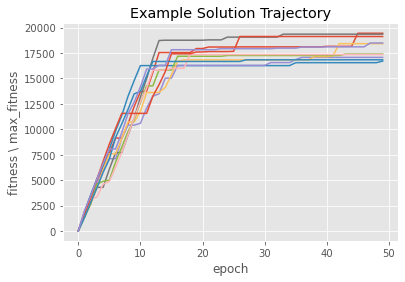

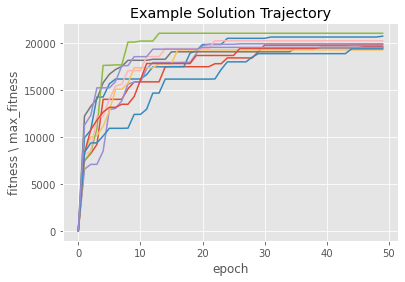

In [5]:
utp.plot_trajectory_evolution(knapSack.Size, 10, 50 ,"to_delete.png")
utp.plot_trajectory_evolution(knapSack.Size, 10, 50, "to_delete.png", model1 )

[INFO]: Loss plot was saved in the directory:  saved_plots\to_delete.png


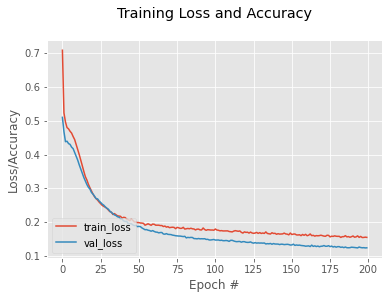

In [15]:

model2 = shallowNet.build(
    input_shape=knapSack.Size, 
    reg_cof= reg_cof, 
    lr = lr, 
    dropout= dropout, 
    compression=compression
)

H2 = model2.fit(
    trainY2, trainY2, 
    validation_split = 0.05,
    epochs=epochs, 
    batch_size=batch_size, 
    shuffle=True,
    verbose=0)
utp.plot_model_loss(H2, "to_delete.png", epochs)

In [16]:
model3 = utm.add_layer_to_model(model2, compression, dropout, reg_cof,lr,True )

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  8080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                5184      
_________________________________________________________________
dense_transpose_4 (DenseTran (None, 80)                5264      
_________________________________________________________________
dense_transpose_3 (DenseTran (None, 100)               818

[INFO]: Loss plot was saved in the directory:  saved_plots\to_delete.png


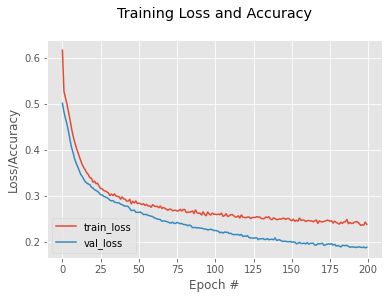

In [17]:
H3 = model3.fit(
    trainY2, trainY2, 
    validation_split = 0.05,
    epochs=epochs, 
    batch_size=batch_size, 
    shuffle=True,
    verbose=0)
utp.plot_model_loss(H3, "to_delete.png", epochs)

[INFO]: number of convoluted layers is equal to:  2
[INFO]: Weights of model were saved in the directory:  saved_plots\to_delete.png


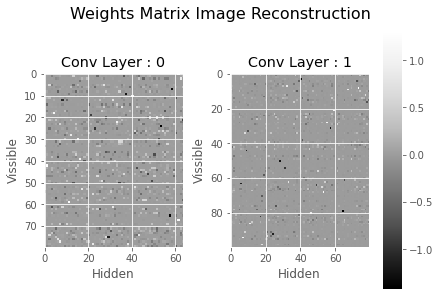

In [18]:
utp.plot_weights_model(model3, "to_delete.png")


[INFO]: Evolution model plot was saved in the directory:  saved_plots\to_delte.png


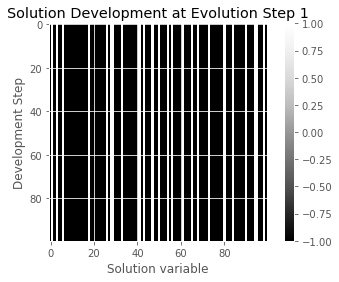

In [31]:
utp.plot_evolution_model(model3, trainY1, "to_delte.png", learning_steps=100)

[INFO]: Fitness development phase plot was saved in the directory:  saved_plots\to_delete.png
[INFO]: Fitness development phase plot was saved in the directory:  saved_plots\to_delete.png


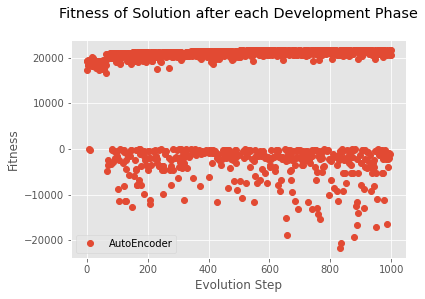

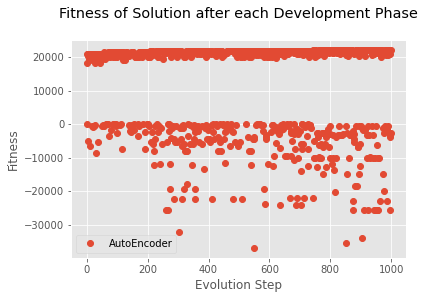

In [20]:
utp.plot_fitness_development_phase(model1, trainY1, "to_delete.png")
utp.plot_fitness_development_phase(model3, trainY1, "to_delete.png")

[INFO]: Trajectory evoultion plot was saved in the directory:  saved_plots\to_delete.png


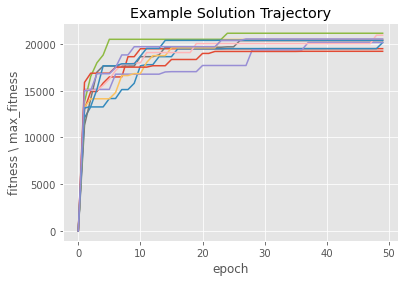

In [23]:
utp.plot_trajectory_evolution(knapSack.Size, 10, 50, "to_delete.png", model3 )

In [32]:
modeltmp = utg.load_models(3)[0]

In [35]:
#utp.plot_weights_model(modeltmp, "to_delete.png")
np.shape(modeltmp.layers[-1].get_weights()[1])

(100, 80)

In [36]:
modeltmp.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                8080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                5184      
_________________________________________________________________
dense_transpose_2 (DenseTran (None, 80)                5264      
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 100)               8180